In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

In [90]:

from scipy.stats import norm

# Define the cumulative distribution function of a normal distribution
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes formula.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.

    Returns:
    float: Price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r * T) * N(d2)

def BS_PUT(S, K, T, r, sigma):
    """
    Calculate the price of a European put option using the Black-Scholes formula.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.

    Returns:
    float: Price of the put option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * N(-d2) - S * N(-d1)

def merton_jump_call(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Calculate the price of a European call option using Merton's jump diffusion model.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    mu_J (float): Mean of the jump size.
    sigma_J (float): Standard deviation of the jump size.
    lam (float): Intensity of the Poisson jump process.

    Returns:
    float: Price of the call option.
    """
    if T <= 0:
        return max(S - K, 0)
    price = 0
    m = np.exp(mu_J)  # Calculate m based on mu_J
    for k in range(40):  # Approximate the infinite series with first 40 terms
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T
        sigma_k = np.sqrt(sigma ** 2 + (k * sigma_J ** 2) / T)
        k_fact = math.factorial(k)
        price += (np.exp(-m * lam * T) * (m * lam * T) ** k / k_fact) * BS_CALL(S, K, T, r_k, sigma_k)
    return price

def merton_jump_put(S, K, T, r, sigma, mu_J, sigma_J, lam):
    """
    Calculate the price of a European put option using Merton's jump diffusion model.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    mu_J (float): Mean of the jump size.
    sigma_J (float): Standard deviation of the jump size.
    lam (float): Intensity of the Poisson jump process.

    Returns:
    float: Price of the put option.
    """
    if T <= 0:
        return max(K - S, 0)
    price = 0
    m = np.exp(mu_J)  # Calculate m based on mu_J
    for k in range(40):  # Approximate the infinite series with first 40 terms
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T
        sigma_k = np.sqrt(sigma ** 2 + (k * sigma_J ** 2) / T)
        k_fact = math.factorial(k)
        price += (np.exp(-m * lam * T) * (m * lam * T) ** k / k_fact) * BS_PUT(S, K, T, r_k, sigma_k)
    return price


In [10]:
def BS_delta(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the delta of a European option.

    Args:
    S (float): Current stock price.
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    option_type (str): Type of the option ('call' or 'put').

    Returns:
    float: Delta of the option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return N(d1)
    else:  # for put option
        return N(d1) - 1

In [12]:


def dynamic_hedge_simulation_3(paths, K, r, sigma, T, dt, rehedge_interval, transaction_cost):
    N = paths.shape[1]
    n_steps = paths.shape[0] - 1
    B0 = 1  # Initial bond price
    
    portfolio_values = np.zeros_like(paths)
    relative_pnl = np.zeros(N)
    
    for j in range(N):  # Loop over each simulation path
        cash = 0
        stock_held = 0
        bond_held = B0
        initial_V_call = BS_CALL(paths[0, j], K, T, r, sigma)
        initial_V_put = BS_PUT(paths[0, j], K, T, r, sigma)
        cash += initial_V_call + initial_V_put  # initial proceeds from selling options
        
        for i in range(n_steps):
            if i % rehedge_interval != 0:
                continue
            S = paths[i, j]
            t = i * dt
            
            # Compute option prices and deltas
            #V_call = BS_CALL(S, K, T - t, r, sigma)
            delta_call = BS_delta(S, K, T - t, r, sigma)
            #V_put = BS_PUT(S, K, T - t, r, sigma)
            delta_put = BS_delta(S, K, T - t, r, sigma, option_type="put")
            
            # Adjusting stock position to match total delta
            desired_stock_position = delta_call + delta_put
            stock_to_buy = desired_stock_position - stock_held
            transaction_costs = np.abs(stock_to_buy * S) * transaction_cost
            cash -= (stock_to_buy * S + transaction_costs)
            stock_held = desired_stock_position
            
            # Bond balance update assuming continuous compounding
            bond_held *= np.exp(r * dt)
            cash *= np.exp(r * dt)
            
            # Update portfolio value
            portfolio_values[i, j] = stock_held * S + cash + bond_held * B0
            
        # Final step calculation
        ST = paths[-1, j]
        VT_call = BS_CALL(ST, K, 0, r, sigma)
        VT_put = BS_PUT(ST, K, 0, r, sigma)
        final_value = stock_held * ST + cash + bond_held * B0 - VT_call - VT_put
        portfolio_values[-1, j] = final_value
        relative_pnl[j] = np.exp(-r * T) * (final_value / (initial_V_call + initial_V_put))
        
    return portfolio_values, relative_pnl


In [85]:


def merton_jump_diffusion_shift(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, N, params1, params2):
    dt = 1 / trading_days  # Time increment based on trading days per year
    n_steps = int(T / dt)  # Number of time steps
    paths = np.zeros((n_steps + 1, N))
    paths[0] = S0

    # Precompute constants
    sqrt_dt = np.sqrt(dt)
    drift1 = (params1['r'] - 0.5 * params1['sigma'] ** 2) * dt
    drift2 = (params2['r'] - 0.5 * params2['sigma'] ** 2) * dt

    # Split the trading days
    half_days = trading_days // 2

    # Simulate the paths
    for t in range(1, n_steps + 1):
        if t <= half_days:
            params = params1
            drift = drift1
        else:
            params = params2
            drift = drift2

        # Standard normal random numbers for GBM
        Z = np.random.standard_normal(N)
        
        # Poisson random numbers for jumps
        J = np.random.poisson(params['lam'] * dt, N)
        
        # Normally distributed jump sizes
        Y = np.random.normal(params['mu_J'], params['sigma_J'], N)
        
        # Calculate the compound jump component
        compound_jump = J * Y
        
        # Update the paths
        paths[t] = paths[t - 1] * np.exp(drift + params['sigma'] * sqrt_dt * Z + compound_jump)

    return paths

# Example usage
params1 = {'r': 0.05, 'sigma': 0.1, 'lam': 0.1, 'mu_J': 0.05, 'sigma_J': 0.1}
params2 = {'r': 0.03, 'sigma': 0.8, 'lam': 0.08, 'mu_J': 0.03, 'sigma_J': 0.08}

S0 = 100
r = 0.05
sigma = 0.2
lam = 0.1
mu_J = 0.05
sigma_J = 0.1
T = 1
trading_days = 256
N = 1000

paths = merton_jump_diffusion_shift(S0, r, sigma, lam, mu_J, sigma_J, T, trading_days, N, params1, params2)


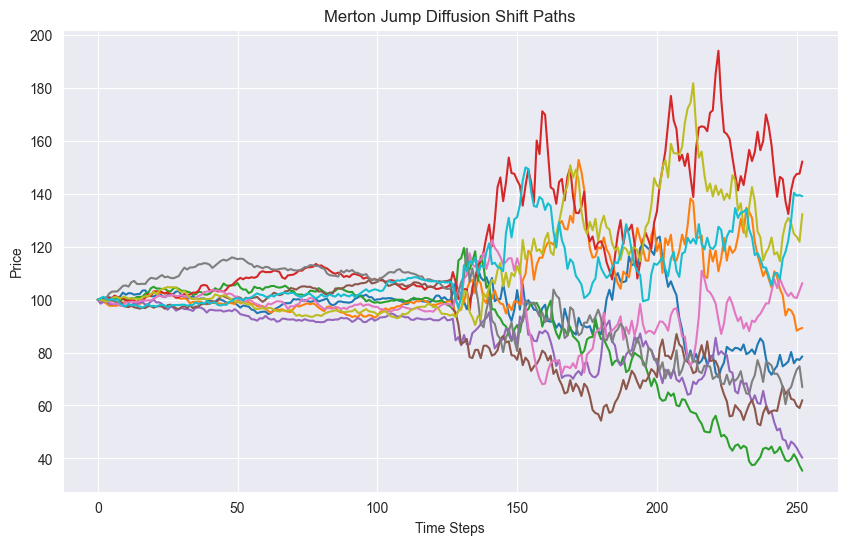

In [3]:
# Plot the paths
plt.figure(figsize=(10, 6))
plt.plot(paths[:, :10])
plt.title('Merton Jump Diffusion Shift Paths')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()

In [70]:
import numpy as np

def generate_black_scholes_paths_shift(S0, r, sigma, T, dt, num_paths, params1, params2):
    """
    Generate Black-Scholes paths using geometric Brownian motion.

    Args:
    S0 (float): Initial stock price.
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the stock.
    T (float): Time to maturity in years.
    dt (float): Time step in years.
    num_paths (int): Number of paths to simulate.
    params1 (dict): Parameters for the first half of trading days.
    params2 (dict): Parameters for the second half of trading days.

    Returns:
    numpy.ndarray: Simulated paths of shape (N+1, num_paths).
    """
    n_steps = int(T / dt)  # Total number of time steps
    paths = np.zeros((n_steps + 1, num_paths))
    paths[0] = S0

    # Split the trading days
    half_steps = n_steps // 2

    # Generate increments of a standard Brownian motion
    # Normal random variables for all paths and time steps
    dW = np.random.normal(0, np.sqrt(dt), (n_steps, num_paths))

    # Precompute constant factors for the exponent
    drift1 = (params1['r'] - 0.5 * params1['sigma']**2) * dt
    drift2 = (params2['r'] - 0.5 * params2['sigma']**2) * dt

    # Compute the paths
    for t in range(1, n_steps + 1):
        if t <= half_steps:
            drift = drift1
            sigma_t = params1['sigma']
        else:
            drift = drift2
            sigma_t = params2['sigma']

        diffusion = sigma_t * dW[t-1]
        paths[t] = paths[t-1] * np.exp(drift + diffusion)

    return paths

# Example usage
params1 = {'r': 0.01, 'sigma': 0.5}
params2 = {'r': 0.01, 'sigma': 0.8}
sigma = 0.5
S0 = 100
r = 0.01

T = 1
dt = 1 / 256
num_paths = 5000

rehedge_interval = 1
transaction_cost = 0.01

paths = generate_black_scholes_paths_shift(S0, r, sigma, T, dt, num_paths, params1, params2)


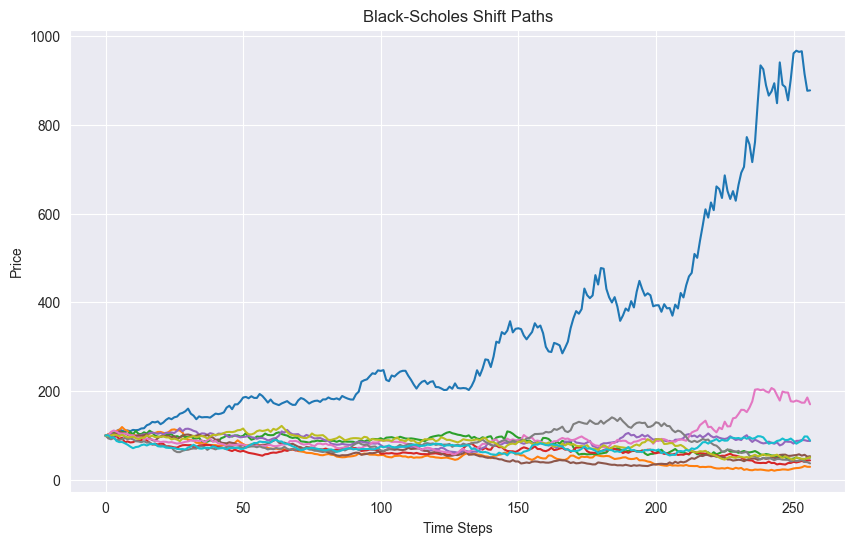

In [71]:
# Plot the paths
plt.figure(figsize=(10, 6))
plt.plot(paths[:, :10])
plt.title('Black-Scholes Shift Paths')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.show()

In [72]:
params1 = {'r': 0.01, 'sigma': 0.4}
params2 = {'r': 0.01, 'sigma': 0.7}
sigma = 0.4

In [73]:
sigma = 0.4
paths1 = generate_black_scholes_paths_shift(S0, r, sigma, T, dt, num_paths, params1, params2)
portfolio_values, relative_pnl1 = dynamic_hedge_simulation_3(
        paths1, 100, r, sigma, T, dt, rehedge_interval, transaction_cost
    )
sigma = 0.7
paths2 = generate_black_scholes_paths_shift(S0, r, sigma, T, dt, num_paths, params2, params1)

C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [74]:
portfolio_values, relative_pnl2 = dynamic_hedge_simulation_3(
        paths2, 100, r, sigma, T, dt, rehedge_interval, transaction_cost
    )

C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


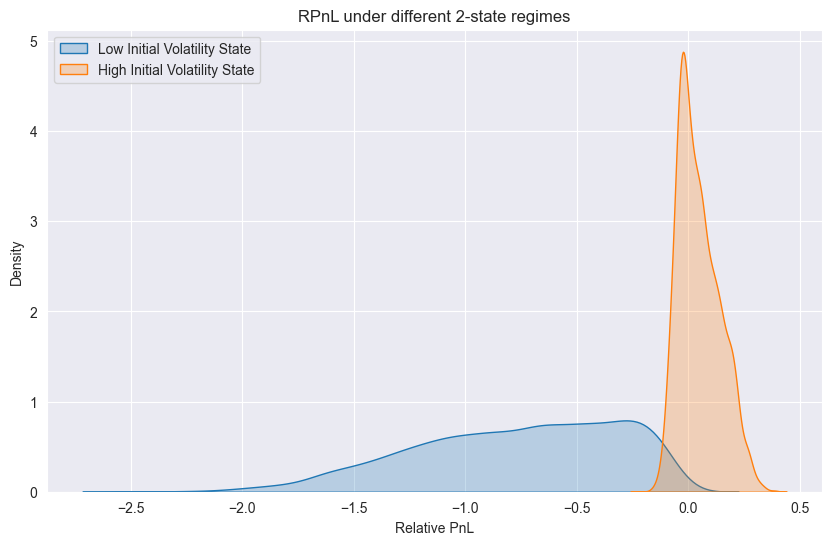

In [76]:
# plot relative pnl density kdeplot
plt.figure(figsize=(10, 6))
sns.kdeplot(relative_pnl1, fill=True)
sns.kdeplot(relative_pnl2, fill=True)
plt.title('RPnL under different 2-state regimes')
plt.xlabel('Relative PnL')
plt.ylabel('Density')
plt.legend(['Low Initial Volatility State', 'High Initial Volatility State'], loc='upper left')
plt.savefig('RPnL_2_state_BS.png')
plt.show()


In [69]:
metrics = []
# get metrics for both states
for pnl in [relative_pnl1, relative_pnl2]:
    metrics.append({
        "Mean": np.mean(pnl),
        "Std": np.std(pnl),
        "VaR 90": np.percentile(pnl, 10),
        "VaR 95": np.percentile(pnl, 5),
        "VaR 99": np.percentile(pnl, 1),
        "CVaR 90": np.mean(pnl[pnl <= np.percentile(pnl, 10)]),
        "CVaR 95": np.mean(pnl[pnl <= np.percentile(pnl, 5)]),
        "CVaR 99": np.mean(pnl[pnl <= np.percentile(pnl, 1)]),
    })
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.round(3)
metrics_df = metrics_df.astype(str).replace("000", "", regex=True)
print(metrics_df.to_latex())

\begin{tabular}{lllllllll}
\toprule
 & Mean & Std & VaR 90 & VaR 95 & VaR 99 & CVaR 90 & CVaR 95 & CVaR 99 \\
\midrule
0 & -0.381 & 0.298 & -0.804 & -0.93 & -1.154 & -0.962 & -1.065 & -1.243 \\
1 & 0.199 & 0.139 & 0.032 & 0.014 & -0.014 & 0.01 & -0.004 & -0.027 \\
\bottomrule
\end{tabular}



In [87]:
num_paths = 5000

In [91]:
transaction_cost = 0.01
hedge_intervals = [1, 2, 4, 8, 16]

pnl_densities_1 = []
sigma = 0.4
paths1 = generate_black_scholes_paths_shift(S0, r, sigma, T, dt, num_paths, params1, params2)
for rehedge_interval in hedge_intervals:
    portfolio_values, relative_pnl = dynamic_hedge_simulation_3(
        paths1, 100, r, sigma, T, dt, rehedge_interval, transaction_cost
    )
    pnl_densities_1.append(relative_pnl)
    
    

C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


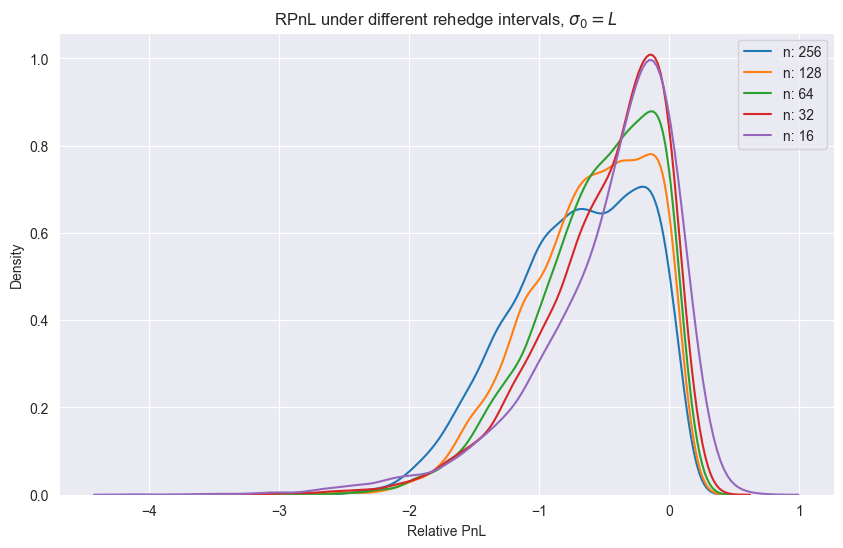

In [93]:
# plot relative pnl density kdeplot
plt.figure(figsize=(10, 6))
for pnl, interval in zip(pnl_densities_1, hedge_intervals):
    sns.kdeplot(pnl, label=f"n: {trading_days//interval}")
    
plt.title('RPnL under different rehedge intervals, $\sigma_0 = L$')
plt.xlabel('Relative PnL')
plt.ylabel('Density')
plt.legend()
plt.savefig('RPnL_rehedge_intervals_2_state_notransact.png')
plt.show()


In [94]:
# get metrics
metrics = []
for pnl in pnl_densities_1:
    metrics.append({
        "Mean": np.mean(pnl),
        "Std": np.std(pnl),
        "VaR 90": np.percentile(pnl, 10),
        "VaR 95": np.percentile(pnl, 5),
        "VaR 99": np.percentile(pnl, 1),
        "CVaR 90": np.mean(pnl[pnl <= np.percentile(pnl, 10)]),
        "CVaR 95": np.mean(pnl[pnl <= np.percentile(pnl, 5)]),
        "CVaR 99": np.mean(pnl[pnl <= np.percentile(pnl, 1)]),
    })
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.round(3)
metrics_df = metrics_df.astype(str).replace("000", "", regex=True)
print(metrics_df.to_latex())

\begin{tabular}{lllllllll}
\toprule
 & Mean & Std & VaR 90 & VaR 95 & VaR 99 & CVaR 90 & CVaR 95 & CVaR 99 \\
\midrule
0 & -0.713 & 0.513 & -1.429 & -1.628 & -1.972 & -1.683 & -1.842 & -2.138 \\
1 & -0.618 & 0.478 & -1.282 & -1.492 & -1.888 & -1.553 & -1.727 & -2.114 \\
2 & -0.557 & 0.471 & -1.22 & -1.436 & -1.905 & -1.517 & -1.712 & -2.107 \\
3 & -0.512 & 0.494 & -1.185 & -1.457 & -2.029 & -1.561 & -1.819 & -2.393 \\
4 & -0.475 & 0.557 & -1.211 & -1.547 & -2.386 & -1.706 & -2.048 & -2.767 \\
\bottomrule
\end{tabular}



In [95]:
sigma = 0.7
paths2 = generate_black_scholes_paths_shift(S0, r, sigma, T, dt, num_paths, params2, params1)
pnl_densities_2 = []
for rehedge_interval in hedge_intervals:
    portfolio_values, relative_pnl = dynamic_hedge_simulation_3(
        paths2, 100, r, sigma, T, dt, rehedge_interval, transaction_cost
    )
    pnl_densities_2.append(relative_pnl)

C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\fabia\AppData\Local\Temp\ipykernel_28852\964115559.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


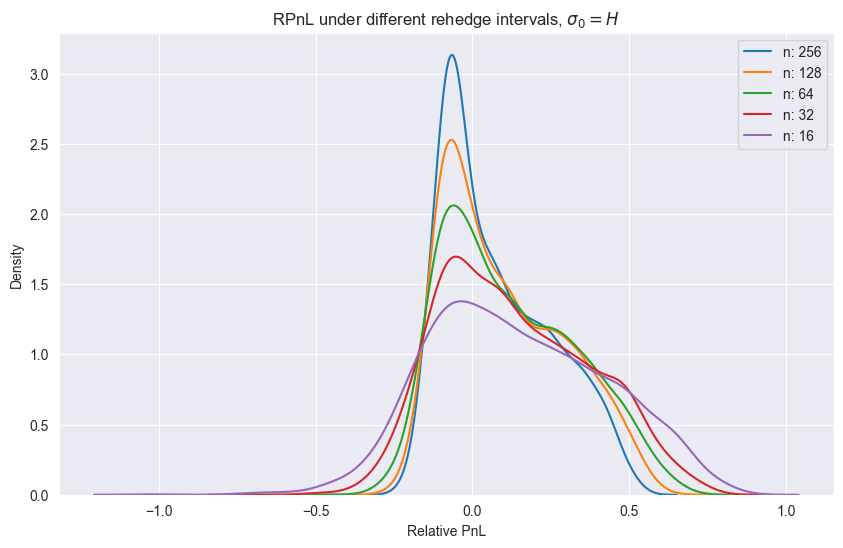

In [96]:
# plot relative pnl density kdeplot
plt.figure(figsize=(10, 6))
for pnl, interval in zip(pnl_densities_2, hedge_intervals):
    sns.kdeplot(pnl, label=f"n: {trading_days//interval}")
    
plt.title('RPnL under different rehedge intervals, $\sigma_0 = H$')
plt.xlabel('Relative PnL')
plt.ylabel('Density')
plt.legend()
plt.savefig('RPnL_rehedge_intervals_2_state_notransact_high.png')
plt.show()

In [97]:
# get metrics
metrics = []
for pnl in pnl_densities_2:
    metrics.append({
        "Mean": np.mean(pnl),
        "Std": np.std(pnl),
        "VaR 90": np.percentile(pnl, 10),
        "VaR 95": np.percentile(pnl, 5),
        "VaR 99": np.percentile(pnl, 1),
        "CVaR 90": np.mean(pnl[pnl <= np.percentile(pnl, 10)]),
        "CVaR 95": np.mean(pnl[pnl <= np.percentile(pnl, 5)]),
        "CVaR 99": np.mean(pnl[pnl <= np.percentile(pnl, 1)]),
    })
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.round(3)
metrics_df = metrics_df.astype(str).replace("000", "", regex=True)
print(metrics_df.to_latex())

\begin{tabular}{lllllllll}
\toprule
 & Mean & Std & VaR 90 & VaR 95 & VaR 99 & CVaR 90 & CVaR 95 & CVaR 99 \\
\midrule
0 & 0.078 & 0.174 & -0.112 & -0.137 & -0.178 & -0.143 & -0.163 & -0.199 \\
1 & 0.101 & 0.192 & -0.115 & -0.144 & -0.194 & -0.152 & -0.176 & -0.223 \\
2 & 0.118 & 0.211 & -0.125 & -0.165 & -0.239 & -0.177 & -0.208 & -0.275 \\
3 & 0.132 & 0.239 & -0.154 & -0.208 & -0.311 & -0.225 & -0.273 & -0.377 \\
4 & 0.144 & 0.279 & -0.191 & -0.264 & -0.44 & -0.299 & -0.373 & -0.557 \\
\bottomrule
\end{tabular}



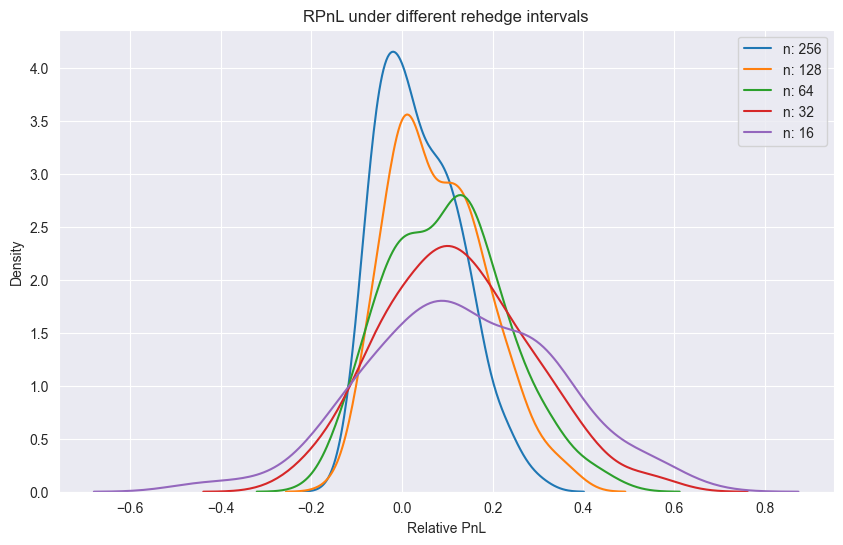

In [86]:
# plot relative pnl density kdeplot
plt.figure(figsize=(10, 6))
for pnl, interval in zip(pnl_densities_2, hedge_intervals):
    sns.kdeplot(pnl, label=f"n: {trading_days//interval}")
    
plt.title('RPnL under different rehedge intervals')
plt.xlabel('Relative PnL')
plt.ylabel('Density')
plt.legend()

plt.show()